In [18]:
# import numpy as np
# n = 0
# R = 280.460 + 0.9856474*n
# g = 357.528 + 0.9856003*n
# ecRon  = R + 1.915*np.sin(g*np.pi/180) + 0.020*np.sin(2*g*np.pi/180)
# print(eclon)

280.3756801972372


In [29]:
# import astropy.time
# import astropy.coordinates

# time = astropy.time.Time("2000-01-01")

# sun = astropy.coordinates.get_body("sun", time = time)
# frame = astropy.coordinates.GeocentricTrueEcliptic(equinox = time)

# lon = sun.transform_to(frame).lon.value

# print(lon)

# sun = astropy.coordinates.get_sun(time)
# frame = astropy.coordinates.GeocentricTrueEcliptic(equinox = time)

# lon = sun.transform_to(frame).lon.value

# print(lon)


279.85921656995856
279.85921816810236


In [125]:
import numpy as np
import pandas as pd
import math

d2r = np.pi/180

def limitAngle(A):
    F = A/360-math.floor(A/360)
    A = 360*F
    return A

L0s = pd.read_csv("SPASRA_L0.csv")
L1s = pd.read_csv("SPASRA_L1.csv")
L2s = pd.read_csv("SPASRA_L2.csv")
L3s = pd.read_csv("SPASRA_L3.csv")
L4s = pd.read_csv("SPASRA_L4.csv")
L5s = pd.read_csv("SPASRA_L5.csv")
Ls = [L0s, L1s, L2s, L3s, L4s, L5s]

B0s = pd.read_csv("SPASRA_B0.csv")
B1s = pd.read_csv("SPASRA_B1.csv")
Bs = [B0s, B1s]

R0s = pd.read_csv("SPASRA_R0.csv")
R1s = pd.read_csv("SPASRA_R1.csv")
R2s = pd.read_csv("SPASRA_R2.csv")
R3s = pd.read_csv("SPASRA_R3.csv")
R4s = pd.read_csv("SPASRA_R4.csv")
Rs = [R0s, R1s, R2s, R3s, R4s]

table2 = pd.read_csv("SPASRA_table2.csv")
Ys = [table2['Y0'], table2['Y1'], table2['Y2'], table2['Y3'], table2['Y4']]

Y = 2023
M = 9
D = 19
deltaT = 69.2
f = 1-0.99664719 #Earth's flattening
sigma = 0 #observer's longitude
phi = 0 #observer's latitude
E = 0 #observer's elevation
P = 1013.25 #local pressure (mbar)
T = 25 #local temperature (C)
omega = 0 #slope of the surface measured from the horizontal plane
gamma = 0 #surface azimuth rotation angle, measured from south to the projection of the surface normal on the horizontal plane

def computeSun(Y, M, D, atmEffects=False, deltaT=69.2, sigma=0, phi=0, E=0, P=1013.25, T=25, omega=0, gamma=0):
    A = math.floor(Y/100)
    B = (2 - A + math.floor(A/4))
    #3.1. Calculate the Julian and Julian Ephemeris Day (JDE), century, and millennium
    if M <= 2:
        Y = Y-1
        M = M+12

    JD = math.floor(365.25*(Y + 4716)) + math.floor(30.6001*(M + 1)) + D + B - 1524.5
    JDE = JD + deltaT/86400
    JC = (JD-2451545)/36525
    JCE = (JDE-2451545)/36525
    JME = JCE/10

    #3.2. Calculate the Earth heliocentric longitude, latitude, and radius vector (L, B, and R):
    #3.2.1:3
    Lis = []
    for i in range(len(Ls)):
        Lis.append(0)
        for j in range(len(Ls[i])):
            Lis[i] = Lis[i] + Ls[i].loc[j, "A"]*np.cos(Ls[i].loc[j, "B"] + JME*Ls[i].loc[j, "C"])
    L = 0
    #3.2.4
    for i in range(len(Lis)):
        L = L + (Lis[i]*JME**i)/(10**8)
    L = L*180/np.pi #3.2.5
    L = limitAngle(L) #3.2.6

    #3.2.7: Repeat #3.2.1:5 for B
    #3.2.1:3
    Bis = []
    for i in range(len(Bs)):
        Bis.append(0)
        for j in range(len(Bs[i])):
            Bis[i] = Bis[i] + Bs[i].loc[j, "A"]*np.cos(Bs[i].loc[j, "B"] + JME*Bs[i].loc[j, "C"])
    B = 0
    #3.2.4
    for i in range(len(Bis)):
        B = B + (Bis[i]*JME**i)/(10**8)
    B = B*180/np.pi #3.2.5

    #3.2.8: Repeat #3.2.1:4 for R
    #3.2.1:3
    Ris = []
    for i in range(len(Rs)):
        Ris.append(0)
        for j in range(len(Rs[i])):
            Ris[i] = Ris[i] + Rs[i].loc[j, "A"]*np.cos(Rs[i].loc[j, "B"] + JME*Rs[i].loc[j, "C"])
    R = 0
    #3.2.4
    for i in range(len(Ris)):
        R = R + (Ris[i]*JME**i)/(10**8)

    #3.3. Calculate the geocentric longitude and latitude (theta and beta):
    theta = L + 180 #3.3.1
    theta = limitAngle(theta) #3.3.2
    beta = -B #3.3.3

    #3.4. Calculate the nutation in longitude and obliquity ( deltaPsi and deltaEpsilon):
    Xs=[0, 0, 0, 0, 0]
    Xs[0] = 297.85036 + 445267.111480 * JCE - 0.0019142 * JCE**2 + (JCE**3)/189474 #3.4.1
    Xs[1] = 357.52772 + 35999.050340 * JCE - 0.0001603 * JCE**2 - (JCE**3)/300000 #3.4.2
    Xs[2] = 134.96298 + 477198.867398 * JCE + 0.0086972 * JCE**2 + (JCE**3)/56250 #3.4.3
    Xs[3] = 93.27191 + 483202.017538 * JCE - 0.0036825 * JCE**2 + (JCE**3)/327270 #3.4.4
    Xs[4] = 125.04452 - 1934.136261 * JCE + 0.0020708 * JCE**2 + (JCE**3)/450000 #3.4.5
    #3.4.6:8
    deltaPsi = 0
    deltaEpsilon = 0
    for i in range(len(table2['a'])):
        summation = 0
        for j in range(4):
            # print("j = %s, X=%s, Y=%s" %(j, Xs[j], Ys[j][i]))
            summation = summation + Xs[j] * Ys[j][i]
        deltaPsi = deltaPsi + ((table2['a'][i] + table2['b'][i] * JCE) * np.sin(summation*d2r))/36000000
        deltaEpsilon = deltaEpsilon + ((table2['c'][i] + table2['d'][i] * JCE) * np.cos(summation*d2r))/36000000

    #3.5. Calculate the true obliquity of the ecliptic, epsilon (in degrees):
    U = JME/10
    epsilon0 = 84381.448 - 4680.93*U - 1.55*U**2 + 1999.25*U**3 - 51.38*U**4 - 249.67*U**5 - 39.05*U**6 + 7.12*U**7 + 27.87*U**8 + 5.79*U**9 + 2.45*U**10 #3.5.1
    epsilon = epsilon0/3600 + deltaEpsilon #3.5.2

    #3.6. Calculate the aberration correction, deltaTau (in degrees):
    deltaTau = -20.4898/(3600*R)

    #3.7. Calculate the apparent sun longitude, lambdaSun (in degrees):
    lambdaSun = theta + deltaPsi + deltaTau

    #3.8. Calculate the apparent sidereal time at Greenwich at any given time, nu (in degrees):
    nu0 = 280.46061837 + 360.98564736629 * (JD - 2451545) + 0.000387933 * JC**2 - (JC**3)/38710000 #3.8.1
    nu0 = limitAngle(nu0) #3.8.2
    nu = nu0 + deltaPsi * np.cos(epsilon*d2r) #3.8.3

    if atmEffects:
        #3.9. Calculate the geocentric sun right ascension, alpha (in degrees)
        alpha = np.arctan2(np.sin(lambdaSun*d2r)*np.cos(epsilon*d2r)-np.tan(beta*d2r)*np.sin(epsilon*d2r), np.cos(lambdaSun*d2r)) #3.9.1
        alpha = limitAngle(alpha/d2r) #3.9.2

        #3.10. Calculate the geocentric sun declination, delta (in degrees)
        delta = np.arcsin(np.sin(beta*d2r)*np.cos(epsilon*d2r)+np.cos(beta*d2r)*np.sin(epsilon*d2r)*np.sin(lambdaSun))
        delta = limitAngle(delta/d2r)

        #3.11. Calculate the observer local hour angle, H (in degrees)
        H = nu + sigma - alpha
        H = limitAngle(H)

        #3.12. Calculate the topocentric sun right ascension alphaPrime (in degrees):
        xi = 8.794/(3600*R) #3.12.1
        u = np.arctan(0.99664719*np.tan(phi)) #3.12.2
        x = np.cos(u) + (E/6378140) * np.cos(phi) #3.12.3
        y = 0.99664719*np.sin(u) + (E/6378140) * np.sin(phi) #3.12.4
        deltaAlpha = np.arctan2(-x*np.sin(xi*d2r)*np.sin(H*d2r), np.cos(delta*d2r)-x*np.sin(xi*d2r)*np.cos(H*d2r)) #3.12.5
        deltaAlpha = deltaAlpha/d2r
        alphaPrime = alpha + deltaAlpha #3.12.6
        deltaPrime = np.arctan2((np.sin(delta*d2r) - y*np.sin(xi*d2r))*np.cos(deltaAlpha*d2r), np.cos(delta*d2r)-x*np.sin(xi*d2r)*np.cos(H*d2r)) #3.12.7

        #3.13. Calculate the topocentric local hour angle, H’ (in degrees),
        Hprime = H - deltaAlpha

        #3.14. Calculate the topocentric zenith angle, Theta (in degrees):
        e0 = np.arcsin(np.sin(phi*d2r)*np.sin(delta*d2r)+np.cos(phi*d2r)*np.cos(delta*d2r)*np.cos(Hprime*d2r)) #3.14.1
        e0 = e0/d2r
        deltae = (P/1010)*(283/(273+T))*(10.2/(60*np.tan((e0 + 10.3/(e0 + 5.11))*d2r))) #3.14.2
        e = e0 + deltae #3.14.3
        Theta = 90 - e #3.14.4

        #3.15. Calculate the topocentric azimuth angle, Phi (in degrees):
        Gamma = np.arctan2(np.sin(Hprime*d2r), np.cos(Hprime*d2r)*np.sin(phi*d2r)-np.tan(deltaPrime*d2r)*np.cos(phi*d2r)) #3.15.1
        Gamma = limitAngle(Gamma/d2r)
        Phi = Gamma + 180 #3.15.2

        #3.16. Calculate the incidence angle for a surface oriented in any direction, I (in degrees):
        I = np.arccos(np.cos(theta)*np.cos(omega) + np.sin(omega)*np.sin(theta)*np.cos(Gamma-gamma))
    return lambdaSun, R

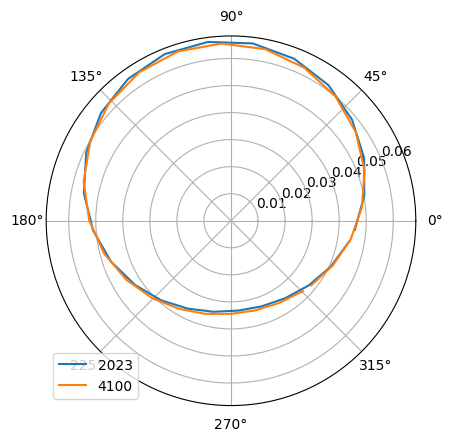

In [189]:
import matplotlib.pyplot as plt

r0 = 0.95
interval = 15
for year in [2023, 4100]:
    thetas = [computeSun(year, 3, 21+interval*i)[0]*d2r for i in range(1+math.floor(365/interval))]
    rs = [computeSun(year, 3, 21+interval*i)[1]-r0 for i in range(1+math.floor(365/interval))]
    plt.polar(thetas, rs, label="%s"%year)

plt.legend()
plt.show()

In [186]:
anomalistic_yr = 365+(6+(13+53/60)/60)/24
tropical_yr    = 365+(5+(48+45/60)/60)/24

print(1/(1/anomalistic_yr+1/tropical_yr))

182.62545707167163
